# Generating Explanation Evaluation

In [18]:
import time
import pandas as pd
from tqdm import tqdm
from langchain_openai import ChatOpenAI
import lib.global_settings as settings
from ShaDoC.generate import generate_explanation
from langchain_core.pydantic_v1 import BaseModel, Field, validator
from langchain_core.output_parsers import JsonOutputParser
from langchain.prompts import PromptTemplate
from langchain_cohere import ChatCohere

import stanza
stanza.download('zh', processors='tokenize')

import os
from dotenv import load_dotenv
load_dotenv(dotenv_path="/Users/sharukat/Documents/ResearchYU/Code/doc-customizer-llm/doc_customizer_llm/.env")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["COHERE_API_KEY"] = os.getenv("COHERE_API_KEY")

from ragas.metrics import faithfulness, answer_relevancy
from ragas import evaluate
from datasets import Dataset
import ast

from selfcheckgpt.modeling_selfcheck_apiprompt import SelfCheckAPIPrompt
selfcheck_prompt = SelfCheckAPIPrompt(client_type="openai", model="gpt-4o")

2024-07-11 15:22:51 INFO: Downloaded file to /Users/sharukat/stanza_resources/resources.json
2024-07-11 15:22:51 INFO: "zh" is an alias for "zh-hans"
2024-07-11 15:22:51 INFO: Downloading these customized packages for language: zh-hans (Simplified_Chinese)...
| Processor | Package |
-----------------------
| tokenize  | gsdsimp |

2024-07-11 15:22:51 INFO: File exists: /Users/sharukat/stanza_resources/zh-hans/tokenize/gsdsimp.pt
2024-07-11 15:22:51 INFO: Finished downloading models and saved to /Users/sharukat/stanza_resources


Initiate OpenAI client... model = gpt-4o


In [51]:
df = pd.read_csv(os.path.join(settings.DATA_PATH, "final_data/eval_dataset_part2.csv"))
df.columns

Index(['QuestionId', 'QuestionAPI', 'IssueType', 'Title', 'Question',
       'GroundTruth', 'course_urls', 'yt_urls', 'retrieve_docs',
       'retrieve_contexts', 'retrieve_context_scores', 'retrieve_so_urls',
       'generated_explanation_x', 'no_context_generated_explanation',
       'faithfulness', 'answer_relevancy', 'retrieve_contexts_new',
       'no_context_faithfulness', 'no_context_answer_relevancy',
       'generated_explanation_y', 'no_doc_context_generated_explanation',
       'generated_samples', 'no_doc_context_generated_samples',
       'gen_selfcheck_scores', 'gen_selfcheck_avg_score',
       'no_context_gen_selfcheck_scores',
       'no_context_gen_selfcheck_avg_score'],
      dtype='object')

In [3]:
def get_documentation(filename):

  filename_with_ext = os.path.join("/Users/sharukat/Documents/ResearchYU/Code/doc-customizer-llm/doc_customizer_llm/ShaDoC/docs", filename) + ".md"  # Add the .md extension
  try:
    with open(filename_with_ext, "r", encoding="utf-8") as file:
      content = file.read()
    return content
  except FileNotFoundError:
    raise ValueError(f"❗ DOCUMENTATION NOT FOUND.\n")

In [16]:
def split_sent(text):
    class Output(BaseModel):
        sentences: list = Field(description="Sentences as a comma separated list")

    parser = JsonOutputParser(pydantic_object=Output)
    format_instructions = parser.get_format_instructions()

    template = """
        Split the entire given response into sentences and return the sentences as comma separated list of sentences.
        {text}

    """
    PROMPT = PromptTemplate(
        template=template,
        input_variables=['text'])

    llm=ChatCohere(model="command-r-plus", temperature=0)
    chain = PROMPT | llm
    prompt = {"text" : text}

    response = chain.invoke(prompt)
    return response

In [22]:
def split_to_sentences(text: str):
    nlp = stanza.Pipeline(lang='en', processors='tokenize', download_method=None, verbose=False)
    doc = nlp(text)
    senteces = [sentence.text for sentence in doc.sentences]
    return senteces

### Prompt 1
Prompt the LLM with relevant information (context).

In [ ]:
results = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    documentation = get_documentation(row["QuestionAPI"])
    solution = generate_explanation(
        documentation=documentation, 
        context=row["retrieve_contexts"], 
        title=row["Title"], 
        question=row["Question"])
    results.append({"generated_explanation":solution.content})

In [ ]:
# Generated samples
results = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    documentation = get_documentation(row["QuestionAPI"])
    samples = []
    for i in range(4):
        solution = generate_explanation(
            documentation=documentation, 
            context=row["retrieve_contexts"], 
            title=row["Title"], 
            question=row["Question"])
        samples.append(solution.content)
    results.append({"generated_samples":samples})

In [ ]:
df_new = pd.DataFrame(results)
merged_df = df.merge(df_new, left_index=True, right_index=True)
merged_df.to_csv(os.path.join(settings.DATA_PATH, "final_data/eval_dataset_part2.csv"),index=False)
merged_df

### Prompt 2
Prompt the LLM without relevant information (context)

In [ ]:
results = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    documentation = get_documentation(row["QuestionAPI"])
    solution = generate_explanation(
        title=row["Title"], 
        question=row["Question"], noContext=True)
    results.append({"no_doc_context_generated_explanation":solution.content})
    

In [ ]:
# Generated samples
results = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    samples = []
    for i in range(4):
        solution = generate_explanation(
            title=row["Title"], 
            question=row["Question"], noContext=True)
        samples.append(solution.content)
    results.append({"no_doc_context_generated_samples":samples})

In [ ]:
df_new = pd.DataFrame(results)
merged_df = df.merge(df_new, left_index=True, right_index=True)
merged_df.to_csv(os.path.join(settings.DATA_PATH, "final_data/eval_dataset_part2.csv"),index=False)
merged_df

## Compute Hallucination

### SelfCheckGPT

In [32]:
# With context
results = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    sentences = split_to_sentences(row["generated_explanation_y"])
    samples = ast.literal_eval(row["generated_samples"])
    sent_scores_prompt = selfcheck_prompt.predict(
        sentences = sentences,  
        sampled_passages = samples, # list of sampled passages
        verbose = False,
    )
    avg_score = average = sum(sent_scores_prompt) / len(sent_scores_prompt)
    res = {"gen_selfcheck_scores": sent_scores_prompt, "gen_selfcheck_avg_score": avg_score}
    results.append(res)

100%|██████████| 22/22 [08:49<00:00, 24.09s/it]


In [39]:
# Without context
results = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    sentences = split_to_sentences(row["no_doc_context_generated_explanation"])
    samples = ast.literal_eval(row["no_doc_context_generated_samples"])
    sent_scores_prompt = selfcheck_prompt.predict(
        sentences = sentences,  
        sampled_passages = samples, # list of sampled passages
        verbose = False,
    )
    avg_score = average = sum(sent_scores_prompt) / len(sent_scores_prompt)
    res = {"gen_selfcheck_scores": sent_scores_prompt, "gen_selfcheck_avg_score": avg_score}
    results.append(res)


100%|██████████| 22/22 [05:04<00:00, 13.85s/it]


In [ ]:
df_new = pd.DataFrame(results)
merged_df = df.merge(df_new, left_index=True, right_index=True)
merged_df.to_csv(os.path.join(settings.DATA_PATH, "final_data/eval_dataset_part2.csv"),index=False)

### RAGAS

In [ ]:
df['retrieve_contexts_new'] = df['retrieve_contexts'].apply(ast.literal_eval)
# df['Title_new'] = df['Title'].apply(lambda x: [x]) 
# contexts = df['retrieve_contexts'].tolist()

data = {"question": df["Question"], "answer": df["no_context_generated_explanation"], "contexts": df['retrieve_contexts_new']}
results = evaluate(Dataset.from_dict(data), metrics=[faithfulness, answer_relevancy])
res = results.to_pandas()
res

In [ ]:
res = res[["faithfulness", "answer_relevancy"]]
res.rename(columns={"faithfulness": "no_context_faithfulness", "answer_relevancy": "no_context_answer_relevancy"}, inplace=True)
res

In [ ]:
merged_df = df.merge(res, left_index=True, right_index=True)
merged_df.to_csv(os.path.join(settings.DATA_PATH, "final_data/eval_dataset_part2.csv"),index=False)
merged_df

## Comparison

In [47]:
type(df["gen_selfcheck_avg_score"][0])

numpy.float64

/var/folders/x7/c7r5kc051js_fytcq8jbvt040000gp/T/ipykernel_4920/3912168389.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(custom_labels)


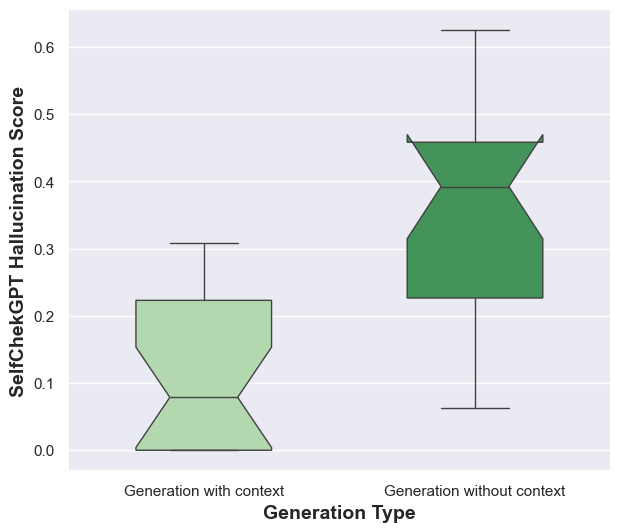

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

matplotlib.rcParams['font.family'] = 'Times New Roman'
sns.set_theme()

df_selected = df[['gen_selfcheck_avg_score', 'no_context_gen_selfcheck_avg_score']]
df_melted = df_selected.melt(var_name='Tool', value_name='SelfCheckGPTScore')

# Create notched box plots
plt.figure(figsize=(7, 6))
ax = sns.boxplot(x='Tool', y='SelfCheckGPTScore', hue='Tool',data=df_melted, notch=True, width=0.5, palette='Greens')
custom_labels = ['Generation with context', 'Generation without context']
ax.set_xticklabels(custom_labels)
# plt.xticks(rotation=15)

# Add title and labels
# plt.title('Notched Box Plots of Tool Performance')
plt.xlabel('Generation Type', fontsize=14, fontweight='bold')
plt.ylabel('SelfChekGPT Hallucination Score', fontsize=14, fontweight='bold')
# plt.savefig('/Users/sharukat/Documents/ResearchYU/Code/doc-customizer-llm/doc_customizer_llm/figures/context_relevancy.pdf')

# Show the plot
plt.show()